In [10]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema, NanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import matplotlib.pyplot as plt
import warnings
import hist.dask as dhist
import dask
import pickle
import os
import dask_awkward as dak
from coffea.lookup_tools.lookup_base import lookup_base

In [2]:
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")

In [3]:
files = os.listdir('/project01/ndcms/cmoore24/samples/hbb/')

hbb = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/samples/hbb/' + files[0]: "/Events"},
    #delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "hbb"},
).events()

In [4]:
genhiggs = hbb.GenPart[
    (hbb.GenPart.pdgId == 25)
    & hbb.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
]
parents = hbb.FatJet.nearest(genhiggs, threshold=0.2)
higgs_jets = ~ak.is_none(parents, axis=1)

cut = (
    (hbb.FatJet.pt > 200)
    & (hbb.FatJet.pt < 2500)
    & (hbb.FatJet.mass > 50)
    & (hbb.FatJet.mass < 200)
    & (abs(hbb.FatJet.eta) < 2.5)
    & (higgs_jets)  
)

In [5]:
hbb_fatjet = hbb.FatJet[cut]

In [6]:
pf = ak.flatten(hbb_fatjet.constituents.pf, axis=1)

In [7]:
jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, 0.8)

In [8]:
cluster = fastjet.ClusterSequence(pf, jetdef)

In [9]:
softdrop = cluster.exclusive_jets_softdrop_grooming()
softdrop_cluster = fastjet.ClusterSequence(softdrop.constituents, jetdef)

In [13]:
cms_n2 = hbb_fatjet.n2b1.compute()
base_n2 = cluster.exclusive_jets_energy_correlator(func="N2").compute()
sd_n2 = softdrop_cluster.exclusive_jets_energy_correlator(func="N2").compute()

In [14]:
# fig, ax = plt.subplots()
# ax.plot(ak.flatten(cms_n2), label='stock nano')
# ax.plot(base_n2, label='base')
# ax.plot(sd_n2, label='sd n2')
# ax.set_xlim(100,150)
# ax.set_ylim(0,0.5)
# plt.legend()
# plt.show()

In [15]:
cms_msd = hbb_fatjet.msoftdrop.compute()
fj_msoftdrop = softdrop.msoftdrop.compute()

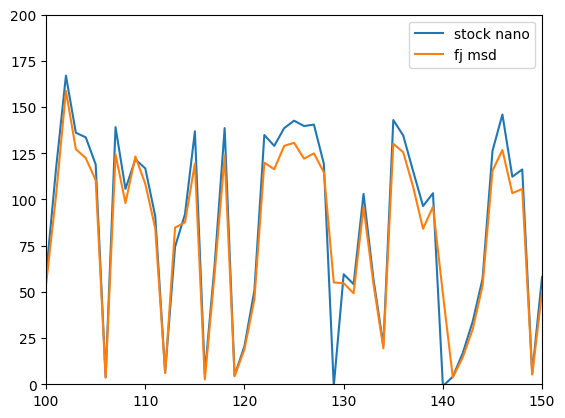

In [18]:
fig, ax = plt.subplots()
ax.plot(ak.flatten(cms_msd), label='stock nano')
ax.plot(fj_msoftdrop, label='fj msd')
ax.set_xlim(100,150)
ax.set_ylim(0,200)
plt.legend()
plt.show()

In [20]:
class SoftDropWeight(lookup_base):
    def _evaluate(self, pt, eta):
        gpar = np.array([1.00626, -1.06161, 0.0799900, 1.20454])
        cpar = np.array([1.09302, -0.000150068, 3.44866e-07, -2.68100e-10, 8.67440e-14, -1.00114e-17])
        fpar = np.array([1.27212, -0.000571640, 8.37289e-07, -5.20433e-10, 1.45375e-13, -1.50389e-17])
        genw = gpar[0] + gpar[1]*np.power(pt*gpar[2], -gpar[3])
        cenweight = np.polyval(cpar[::-1], pt)
        forweight = np.polyval(fpar[::-1], pt)
        weight = np.where(np.abs(eta) < 1.3, cenweight, forweight)
        return genw*weight

In [21]:
_softdrop_weight = SoftDropWeight()

In [22]:
def corrected_msoftdrop(fatjets):
    sf = _softdrop_weight(fatjets.pt, fatjets.eta)
    sf = np.maximum(1e-5, sf)
    dazsle_msd = (fatjets.subjets * (1 - fatjets.subjets.rawFactor)).sum()
    return dazsle_msd.mass * sf

In [24]:
hbb_fatjet = hbb_fatjet.compute()

In [26]:
pt = ak.flatten(hbb_fatjet.pt)
eta = ak.flatten(hbb_fatjet.pt)
gpar = np.array([1.00626, -1.06161, 0.0799900, 1.20454])
cpar = np.array([1.09302, -0.000150068, 3.44866e-07, -2.68100e-10, 8.67440e-14, -1.00114e-17])
fpar = np.array([1.27212, -0.000571640, 8.37289e-07, -5.20433e-10, 1.45375e-13, -1.50389e-17])
genw = gpar[0] + gpar[1]*np.power(pt*gpar[2], -gpar[3])
cenweight = np.polyval(cpar[::-1], pt)
forweight = np.polyval(fpar[::-1], pt)
weight = np.where(np.abs(eta) < 1.3, cenweight, forweight)
sf = genw*weight
sf = np.maximum(1e-5, sf)
dazsle_msd = (hbb_fatjet * (1 - hbb_fatjet.rawFactor)).sum()

In [33]:
mass = dazsle_msd.mass[dazsle_msd.mass > 0]

In [34]:
check = mass * sf

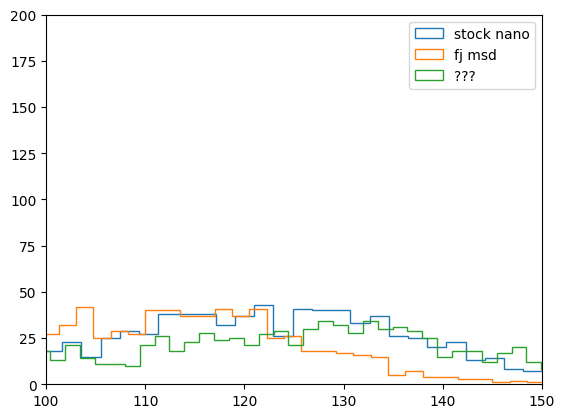

In [47]:
fig, ax = plt.subplots()
ax.hist(ak.flatten(cms_msd), label='stock nano', bins=100, histtype='step')
ax.hist(fj_msoftdrop, label='fj msd', bins=100, histtype='step')
ax.hist(check, label='???', bins=100, histtype='step')
ax.set_xlim(100,150)
ax.set_ylim(0,200)
plt.legend()
plt.show()